# Classifier notebook has more explanations

In [1]:
import numpy as np
import tensorflow as tf
from enum import Enum
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d

In [2]:
with open('data/batch1.pkl', 'rb') as f:
    batch1 = np.load(f)
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

with open('data/batch2.pkl', 'rb') as f:
    batch2 = np.load(f)
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

with open('data/batch3.pkl', 'rb') as f:
    batch3 = np.load(f)
    
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

batch1_size = len(batch1.keys())
batch2_size = len(batch2.keys())
batch3_size = len(batch3.keys())

batch_size = batch1_size + batch2_size + batch3_size

batches = {**batch1, **batch2, **batch3}

del batch1
del batch2
del batch3

In [3]:
test_ind = np.hstack((np.arange(0,(batch1_size+batch2_size),2),83))
train_ind = np.arange(1,(batch1_size+batch2_size-1),2)
secondary_test_ind = np.arange(batch_size-batch3_size,batch_size)

Text(0, 0.5, 'Discharge Capacity (Ah)')

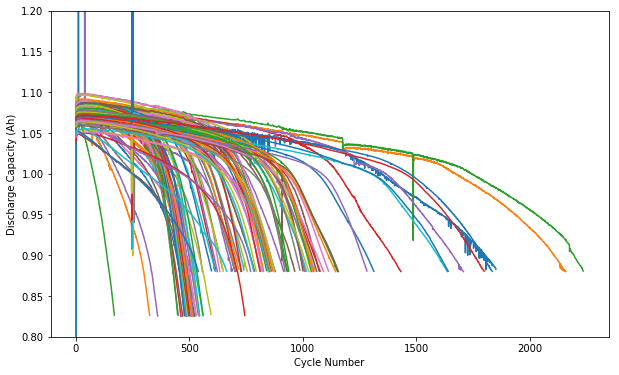

In [4]:
plt.figure(figsize=(10,6))
for i in batches.keys():
    plt.plot(batches[i]['summary']['cycle'], batches[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylim(0.8, 1.2)
plt.ylabel('Discharge Capacity (Ah)')

In [5]:
print('Cell count: ', len(batches))
print('Cell names: ', batches.keys())

cell = batches['b1c23']

Cell count:  124
Cell names:  dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3

In [6]:
def get_QV(cycle, num=1000):
    V = cycle['V']
    Qd = cycle['Qdlin']
    v = np.linspace(np.max(V), np.min(V), num=len(Qd), endpoint=True)
    return Qd, v

In [7]:
# How many cycles to look at?
n_cycles = 100
n_inputs = 1000

N_EPOCHS = 1000

In [8]:
class ModelType(Enum):
    VARIANCE = 0
    DISCHARGE = 1
    FULL = 2

In [9]:
def get_dataset(d, model_type, n_cycles, n_inputs):
    
    if model_type == ModelType.DISCHARGE:
        keys = ['Qd']
        n_features = len(keys)
    elif model_type == ModelType.FULL:
        keys = next(iter(d.values()))['cycles']['0'].keys()
        n_features = len(keys)
    else:
        n_features = 1

    cycle_lives = [cell['cycle_life'].flatten() for cell in d.values()]
    data = None
    variances = np.empty(shape=(len(d), 1))
    for idx, (name, cell) in enumerate(d.items()):
        
        if model_type == ModelType.VARIANCE:
            features = np.empty(shape=(1,), dtype=np.float32)
        else:
            features = np.zeros(shape=(n_cycles, n_features+1, n_inputs), dtype=np.float32)
            for i in range(n_cycles):
                cycle = cell['cycles'][str(i)]
                for j, key in enumerate(keys):
                    choice = np.linspace(0, num=n_inputs, stop=len(values), endpoint=False, dtype=np.int64)
                    values = cycle[key]
                    values = values[choice]
                    features[i,j+1,:] = values
                    
        qd10, v = get_QV(cell['cycles'][str(10)])
        qd100, v = get_QV(cell['cycles'][str(100)])
        q_var = np.log(np.var(qd100 - qd10))
        features[-1] = q_var

        y = cell['cycle_life'].squeeze()
        xy = [features, y]
        if data is None:
            data = xy
        else:
            data = np.vstack([data, xy])
    return data

model_type = ModelType.VARIANCE
data = get_dataset(batches, model_type, n_cycles, n_inputs)

data_train = data[train_ind]
data_val = data[test_ind]
data_test = data[secondary_test_ind]

In [10]:
'''
Just a simple linear MLP.
'''
class BaselineModel(Model):
    def __init__(self, n_inputs, n_layers=3, n_neurons=32):
        super(BaselineModel, self).__init__()
        
        l1reg = 0.8
        l2reg = (1.0-l1reg)/2
    
        lambda_ = 1e-2
        l1reg *= lambda_
        l2reg *= lambda_
        
        layers = []
        layers.append(Dense(n_neurons, activation='relu', input_shape=(1,),
                      kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        for _ in range(n_layers-1):
            layers.append(Dense(n_neurons, activation='relu',
                                kernel_regularizer=l1_l2(l1=l1reg, l2=l2reg)))
        self.hidden_layers = layers
        self.out = Dense(1)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.out(x)

model = BaselineModel(n_inputs)

In [11]:
loss_fn = tf.keras.losses.MeanSquaredError()
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=lr/(N_EPOCHS))

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
train_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='train_mape')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
val_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='val_mape')

In [12]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
                
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    train_loss(loss)
    train_mse(y, predictions)
    train_mape(y, predictions)

In [13]:
@tf.function
def val_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
  
    val_loss(loss)
    val_mse(y, predictions)
    val_mape(y, predictions)

Epoch 100
Loss: 100983.6328125, RMSE: 317.7792053222656, Mean absolute % error: 32.52546691894531
Val loss: 187229.53125, RMSE: 432.7002868652344, Mean absolute % error: 27.425878524780273


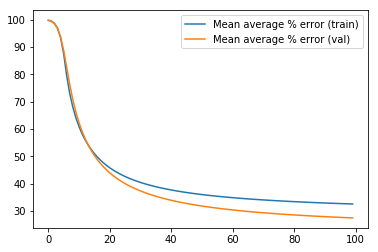

Epoch 200
Loss: 86813.1875, RMSE: 294.6407775878906, Mean absolute % error: 30.557395935058594
Val loss: 159432.515625, RMSE: 399.2900085449219, Mean absolute % error: 24.881553649902344


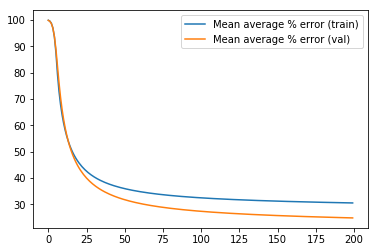

Epoch 300
Loss: 81175.6640625, RMSE: 284.9134216308594, Mean absolute % error: 29.720073699951172
Val loss: 148219.125, RMSE: 384.99237060546875, Mean absolute % error: 23.770565032958984


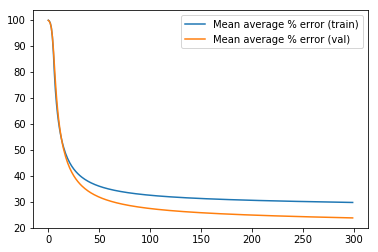

Epoch 400
Loss: 77481.515625, RMSE: 278.3550109863281, Mean absolute % error: 29.115558624267578
Val loss: 140800.9375, RMSE: 375.2344970703125, Mean absolute % error: 22.983627319335938


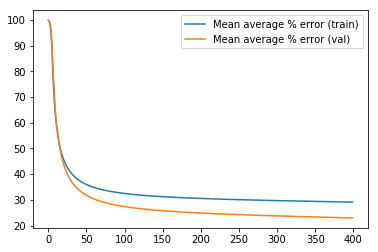

Epoch 500
Loss: 74253.265625, RMSE: 272.4945373535156, Mean absolute % error: 28.52498435974121
Val loss: 134331.046875, RMSE: 366.5119934082031, Mean absolute % error: 22.251420974731445


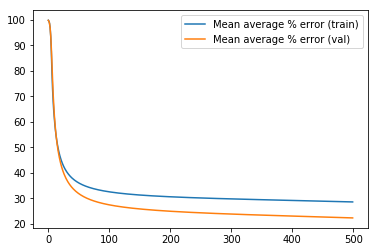

Epoch 600
Loss: 70662.78125, RMSE: 265.82470703125, Mean absolute % error: 27.783737182617188
Val loss: 127257.3125, RMSE: 356.7314147949219, Mean absolute % error: 21.38881492614746


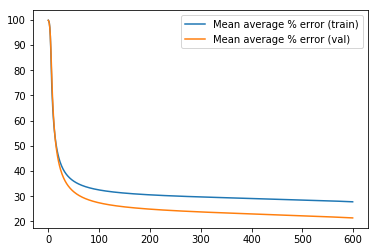

Epoch 700
Loss: 65897.921875, RMSE: 256.7059020996094, Mean absolute % error: 26.767803192138672
Val loss: 118063.109375, RMSE: 343.6031188964844, Mean absolute % error: 20.30139923095703


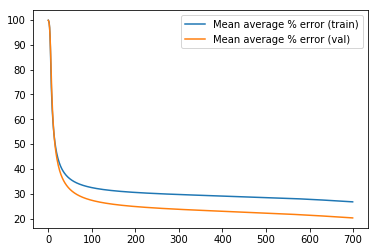

Epoch 800
Loss: 60456.47265625, RMSE: 245.8789825439453, Mean absolute % error: 25.865524291992188
Val loss: 107770.3125, RMSE: 328.2839050292969, Mean absolute % error: 19.27560043334961


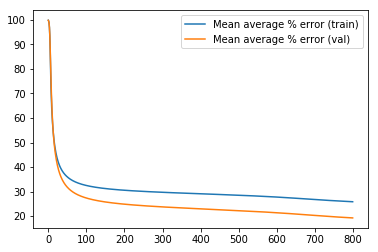

Epoch 900
Loss: 55680.515625, RMSE: 235.96719360351562, Mean absolute % error: 25.098613739013672
Val loss: 99175.4296875, RMSE: 314.9212951660156, Mean absolute % error: 18.566631317138672


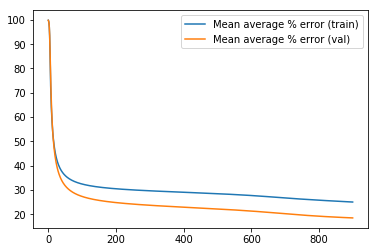

Epoch 1000
Loss: 51789.81640625, RMSE: 227.57376098632812, Mean absolute % error: 24.439006805419922
Val loss: 92299.9453125, RMSE: 303.8090515136719, Mean absolute % error: 18.048107147216797


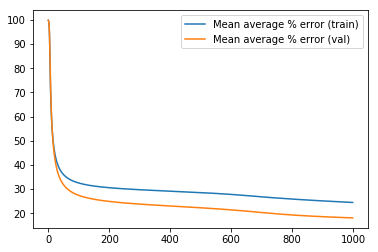

In [14]:
train_rmses, train_mapes, val_rmses, val_mapes = [], [], [], []

log_step = 100

for epoch in range(N_EPOCHS):
    
    for x, y in data_train:
        train_step(np.array([x]), np.array([y]))

    for x, y in data_test:
        val_step(np.array([x]), np.array([y]))
        
    train_rmses.append(np.sqrt(train_mse.result()))
    val_rmses.append(np.sqrt(val_mse.result()))
    train_mapes.append(train_mape.result())
    val_mapes.append(val_mape.result())
    
    if (epoch+1) % log_step == 0:
        template = ('Epoch {}\n'
                    'Loss: {}, RMSE: {}, Mean absolute % error: {}\n'
                    'Val loss: {}, RMSE: {}, Mean absolute % error: {}')
        print(template.format(epoch+1,
                             train_loss.result(), 
                             train_rmses[-1],
                             train_mapes[-1],
                             val_loss.result(), 
                             val_rmses[-1],
                             val_mapes[-1]))
        
        plt.figure()
        plt.plot(train_mapes, label='Mean average % error (train)')
        plt.plot(val_mapes, label='Mean average % error (val)')
        plt.legend()
        plt.show()

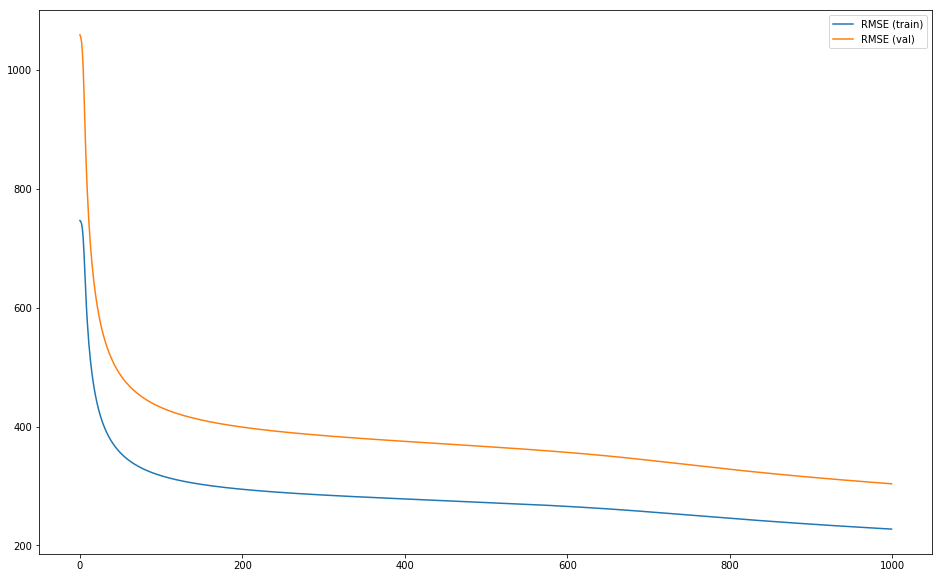

In [15]:
plt.figure(figsize=(16,10))
plt.plot(train_rmses, label='RMSE (train)')
plt.plot(val_rmses, label='RMSE (val)')
plt.legend()
plt.show()

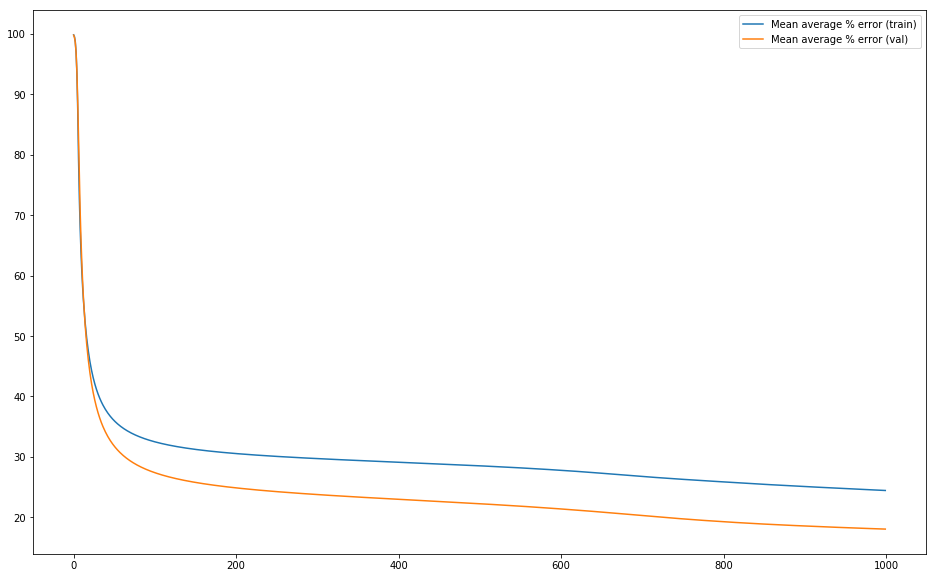

In [16]:
plt.figure(figsize=(16,10))
plt.plot(train_mapes, label='Mean average % error (train)')
plt.plot(val_mapes, label='Mean average % error (val)')
plt.legend()
plt.show()

# From paper:
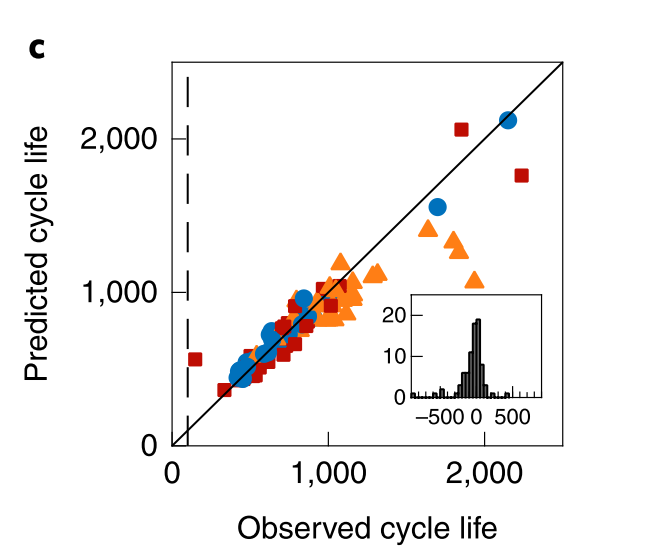

Shapes correspond to training/validation/test set.

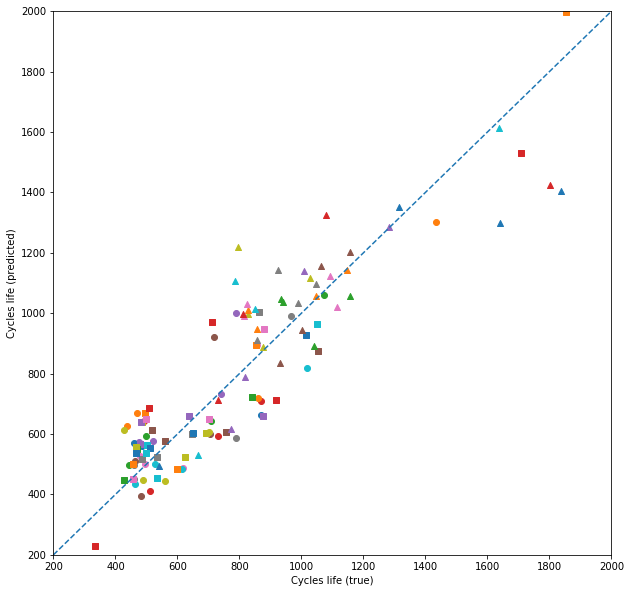

In [17]:
plt.figure(figsize=(10,10))


for x, y_true in data_train:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred)
    
for x, y_true in data_val:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred, marker='s')
    
for x, y_true in data_test:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred, marker='^')

lim_min, lim_max = 200, 2000

plt.ylabel('Cycles life (predicted)')
plt.xlabel('Cycles life (true)')
plt.axis([lim_min, lim_max, lim_min, lim_max])
plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='--')
plt.show()

# Ignore training/validation set

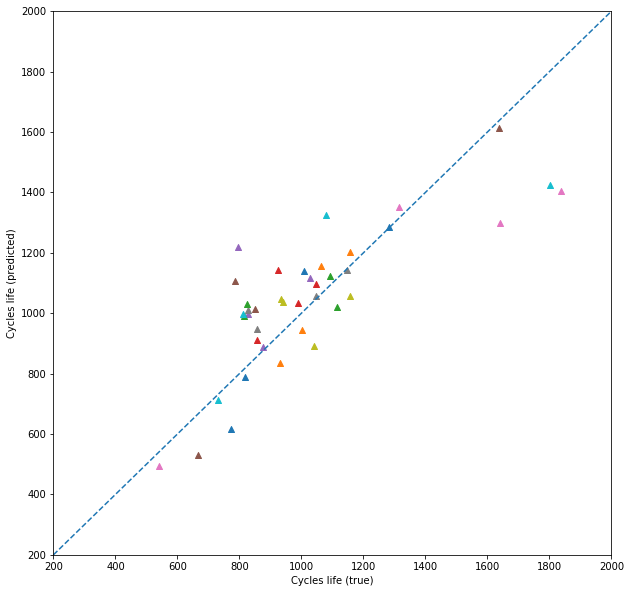

In [18]:
plt.figure(figsize=(10,10))

for x, y_true in data_test:
    y_pred = model(np.array([x]))
    plt.scatter(y_true, y_pred, marker='^')

lim_min, lim_max = 200, 2000

plt.ylabel('Cycles life (predicted)')
plt.xlabel('Cycles life (true)')
plt.axis([lim_min, lim_max, lim_min, lim_max])
plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='--')
plt.show()